In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import warnings

In [2]:
import sys
sys.path.insert(0, '../')

from dynamical_model import DynamicalModel

In [3]:
## default values to test with
r_eff = 1.85
theta_e = 1.63
gamma = 1.95

## test single aperture calculation

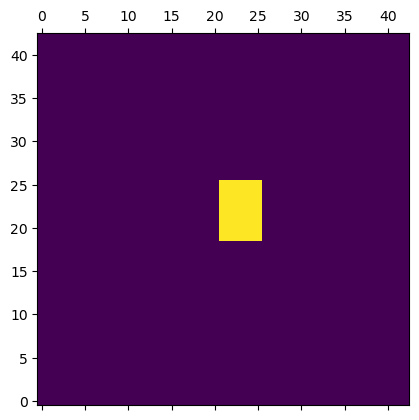

In [4]:
binning = np.zeros((43, 43))

binning[22-3:22+4, 23-2:23+3] = np.ones((7, 5))

plt.matshow(binning, origin='lower')

### test single aperture vs Voronoi binning in `Galkin`

In [5]:
anisotropy_model = 'constant'
ani_param = 0.

dyn_model = DynamicalModel(mass_profile='powerlaw')

for i in range(1):
    # binned
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    
    np.random.seed(i)
    
    a = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                       theta_e,
                                       gamma, 
                                       ani_param=ani_param,
                                       anisotropy_model=anisotropy_model,
                                       supersampling_factor=2, 
                                       aperture='ifu',
                                       voronoi_bins=binning-1 #binning-1
                                      )
    
    # single-slit
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=True
    )
    
    np.random.seed(i)
    b = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                       theta_e,
                                       gamma, 
                                       ani_param=ani_param,
                                       anisotropy_model=anisotropy_model,
                                       supersampling_factor=5, 
                                       aperture='single_slit',
                                       voronoi_bins=binning-1 #binning-1
                                      )
    
    print(a[0][0], b[0])
    
    if np.abs(a[0][0] - b[0])/a[0][0] > 0.3/100:
        warnings.warn('Voronoi binning in galkin only fails! 🙁')
    else:
        print('Models match within 0.3%. 🙂')

370.89782505625885 371.4869933068478
Models match within 0.3%. 🙂


### test single-aperture-like Voronoi bins in galkin vs jampy

In [6]:
anisotropy_model = 'constant'
ani_param = 0.

dyn_model = DynamicalModel(mass_profile='powerlaw')

for i in range(1):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    a = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                           theta_e,
                                           gamma, 
                                           ani_param=ani_param,
                                           anisotropy_model=anisotropy_model,
                                           supersampling_factor=5, 
                                           aperture='ifu',
                                           voronoi_bins=binning-1 #binning-1
                                           )
    
    
    np.random.seed(i)
    b = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            ani_param=np.sqrt(1-ani_param),
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=True,
                                            voronoi_bins=binning-1
                                           )
    
    print(a[0][0], b[0][0])
    
    if np.abs(a[0][0] - b[0][0])/a[0][0] > 0.8/100:
        warnings.warn('Voronoi binning between galkin and jampy doesn\'t agree! 🙁')
    else:
        print('Models match within 0.8%. 🙂')

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
370.61291752037295 369.82775551400346
Models match within 0.8%. 🙂


## IFU test

### constant

(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


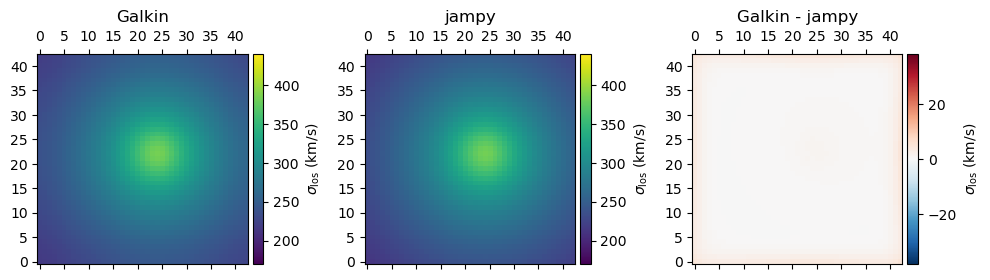

In [7]:
dyn_model.PSF_FWHM = 0.7
anisotropy_model = 'constant'
ani_param = 0. # isotropic

dyn_model = DynamicalModel(mass_profile='powerlaw')
    
for i in range(10):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    a, _ = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                           theta_e,
                                           gamma, 
                                           ani_param=ani_param,
                                           anisotropy_model=anisotropy_model,
                                           supersampling_factor=5, 
                                           aperture='ifu',
                                           voronoi_bins=None #binning-1
                                           )
    print(a.shape)
    
    np.random.seed(i)
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            ani_param=np.sqrt(1-ani_param),
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=True,
                                            voronoi_bins=None
                                           )
    print(b.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    
    def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
        divider = make_axes_locatable(axes[i])
        im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')
        
    #cbar = axes[0].matshow(a[0], origin='lower')
    #cbar = axes[1].matshow(b[0], origin='lower')
    #plt.colorbar(cbar)

    #cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
    #plt.colorbar(cbar)
    plot_mat(a.reshape((43, 43)), 0, cmap='viridis')
    plot_mat(b.reshape((43, 43)), 1, cmap='viridis')
    plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
             vmax=np.max(b)*0.1, vmin=-np.max(b)*0.1)
    
    axes[0].set_title('Galkin')
    axes[1].set_title('jampy')
    axes[2].set_title('Galkin - jampy')
    
    fig.tight_layout()
    break

### Osipkov-Merritt

(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


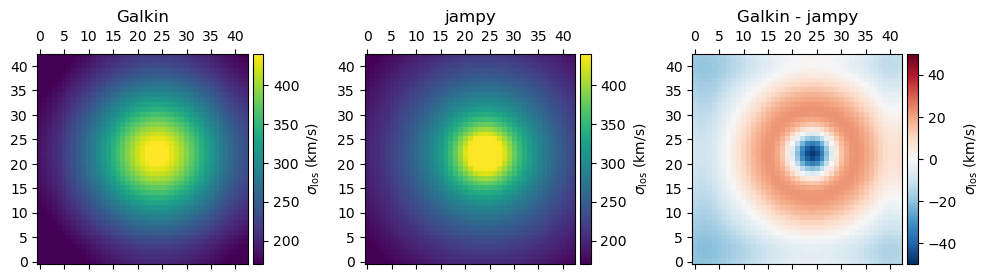

In [8]:
anisotropy_model = 'Osipkov-Merritt'
ani_param = 2

dyn_model.PSF_FWHM = 0.7

for i in range(10):
    kinematics_api = dyn_model.get_galkin_kinematics_api(
        anisotropy_model=anisotropy_model,
        single_slit=False
    )
    np.random.seed(i)
    dyn_model = DynamicalModel(mass_profile='powerlaw')
    a, _ = dyn_model.compute_galkin_v_rms_model(kinematics_api,
                                           theta_e,
                                           gamma, 
                                           ani_param=ani_param,
                                           anisotropy_model=anisotropy_model,
                                           supersampling_factor=5, 
                                           aperture='ifu',
                                           voronoi_bins=None, #binning-1
                                           )
    print(a.shape)
    
    np.random.seed(i)
    b, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                            gamma,
                                            ani_param=ani_param,
                                            anisotropy_model=anisotropy_model,
                                            supersampling_factor=5,
                                            is_spherical=True,
                                            voronoi_bins=None
                                           )
    print(b.shape)
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
    
    def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
        divider = make_axes_locatable(axes[i])
        im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')
        
    #cbar = axes[0].matshow(a[0], origin='lower')
    #cbar = axes[1].matshow(b[0], origin='lower')
    #plt.colorbar(cbar)

    #cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
    #plt.colorbar(cbar)
    plot_mat(a.reshape((43, 43)), 0, cmap='viridis')
    plot_mat(b.reshape((43, 43)), 1, cmap='viridis')
    plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=np.max(b)*0.1, vmin=-np.max(b)*0.1)
    
    axes[0].set_title('Galkin')
    axes[1].set_title('jampy')
    axes[2].set_title('Galkin - jampy')
    
    fig.tight_layout()
    break

## elliptical case

### check difference between n_gauss settings

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
(43, 43)


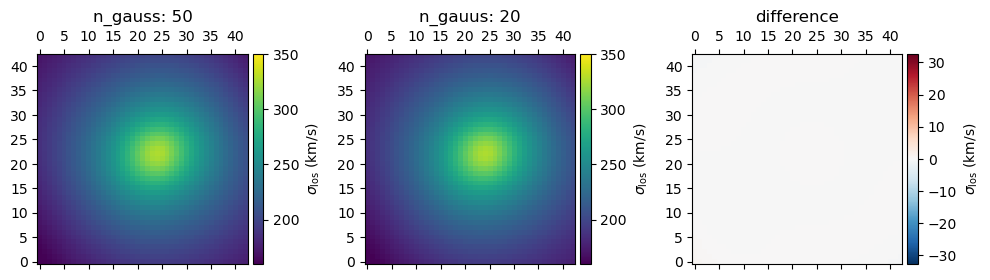

In [9]:
anisotropy_model = 'constant'
ani_param = 0.

n_gauss_1 = 50
n_gauss_2 = 20

dyn_model = DynamicalModel(mass_profile='powerlaw', n_gauss=n_gauss_1)
np.random.seed(2)
a, _ = dyn_model.compute_jampy_v_rms_model(theta_e,
                                        gamma,
                                        q=0.6, pa=121,
                                        ani_param=np.sqrt(1-ani_param),
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None
                                       )
print(a.shape)

dyn_model_2 = DynamicalModel(mass_profile='powerlaw', n_gauss=n_gauss_2)
np.random.seed(2)
b, _ = dyn_model_2.compute_jampy_v_rms_model(theta_e,
                                        gamma,
                                        q=0.6, pa=121,
                                        ani_param=np.sqrt(1-ani_param),
                                        anisotropy_model=anisotropy_model,
                                        supersampling_factor=5,
                                        voronoi_bins=None
                                       )

print(b.shape)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
#axes = [axes]

def plot_mat(arr, i, cmap='viridis', vmax=440, vmin=170):
    divider = make_axes_locatable(axes[i])
    im = axes[i].matshow(arr, origin='lower', cmap=cmap, vmax=vmax, vmin=vmin)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical', label=r'$\sigma_{\rm los}$ (km/s)')

#cbar = axes[0].matshow(a[0], origin='lower')
#cbar = axes[1].matshow(b[0], origin='lower')
#plt.colorbar(cbar)

#cbar = axes[2].matshow(a[0] - b[0], origin='lower', cmap='RdBu')
#plt.colorbar(cbar)
plot_mat(a.reshape((43, 43)), 0, cmap='viridis', vmax=350, vmin=160)
plot_mat(b.reshape((43, 43)), 1, cmap='viridis', vmax=350, vmin=160)
plot_mat(a.reshape((43, 43)) - b.reshape((43, 43)), 2, cmap='RdBu_r', 
         vmax=np.max(b)*0.1, vmin=-np.max(b)*0.1)

axes[0].set_title('n_gauss: {}'.format(n_gauss_1))
axes[1].set_title('n_gauus: {}'.format(n_gauss_2))
axes[2].set_title('difference')

fig.tight_layout()